# Implémentation d'un réseau de neurones avec Numpy

Ce notebook vous propose d'implémenter votre propre réseau de neurones dans Numpy et de l'entrainer à reconnaitre des chiffres. On commencera avec une sigmoide, puis on généralisera à un perceptron multi couches. 

L'objectif est de coder toutes les briques nécessaires à la définition et à l'entrainement du modèle par descente de gradient (stochastique).

<i> Repris et adapté d'un TD de Francois Pierre Paty </i>

In [1]:
# Librairies

import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.datasets import load_digits # chargement qui peut être un peu long.
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

## Données

Dans un premier temps, on charge et on prépare les données. 

### Chargement et visualisation

<class 'numpy.ndarray'>
(8, 8)
0.0 16.0


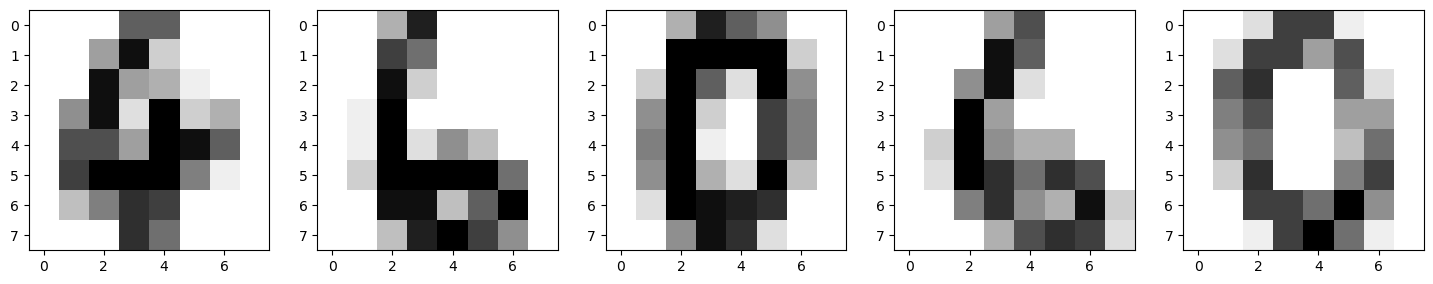

In [2]:
digits = load_digits() # chargement du jeu de données

# affichage de quelques exemples 

#seed pour la reproducibilité
random.seed(42)

fig, ax = plt.subplots(1,5, figsize = (18, 4)) # une ligne de 5 vignettes pour afficher des échantillons

for i in range(5):

    # tirer une image dans la base de données
    sample_index = np.random.randint(0,digits.images.shape[0])
    sample_image = digits.images[sample_index]
    ax[i].imshow(sample_image, cmap = "gray_r", interpolation = "nearest")


# caractéristiques des données pour savoir avec quels objets on travaille
print(type(sample_image))
print(sample_image.shape)
print(np.min(sample_image), np.max(sample_image))

plt.show()

Les données sont des matrices $8\times 8$. La valeur de chaque entrée varie entre 0 et 16. Cette valeur correspond à l'intensité du pixel. 

### Préparation des données

A présent, on sépare les données entre une base d'entrainement et une base de test. On normalize également les données. 


In [3]:
data = np.asarray(digits.data, dtype='float32')
labels = np.asarray(digits.target, dtype='int32') # correspond aux labels (i.e. chiffres)

test_size = 0.25 # proportion de la base de données qu'on consacre au test 

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size)

# mean = 0 and standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modèles 


### Préliminaires

Dans cette section, on implémente une régression logistique que l'on entraine par descente de gradient. Les objectifs sont:

* Implémenter un modèle <i> forward </i> simple, sans couche cachée (a.k.a. régression logistique) de la forme 
  
  $$
  y = \sigma\left(\mathbf{W} x + b\right)
  $$
où $\sigma(x)$ est la [fonction softmax](https://fr.wikipedia.org/wiki/Fonction_softmax).

* Construire une fonction de prédiction qui retourne le label $y$ le plus probable pour un input $x$ donné
* Construire une fonction de précision pour un batch d'inputs $\mathbf{X}$ et leurs outputs correspondants $\mathbf{y}$.
* Construire le gradient qui calcule $\frac{d}{dW} -\log(\sigma(W x + b))$ pour un $x$ et un $y$ donnés
* Constuire une fonction d'entrainement qui utilise le gradient pour mettre à jour les poids $W$ et $b$.

#### Encodage one-hot des labels

Avant de commencer, on va définir une fonction qui calcule l'encodage one-hot pour un nombre de classes données. Avec cette fonction, on représente les labels des $K$ classes par un vecteur $y\in\{0,1\}^K$, où la $k$ème coordonnée vaut 1 si le label de l'input correspond à la classe $k$, et 0 partout ailleurs. Par exemple, si on a trois classes "Bleu", "Blanc", "Rouge", alors on encode les labels des inputs qui appartiennent à la classe "Bleu" comme suit : $(1, 0, 0)$ ; ceux de la classe blanc $(0, 1, 0)$ et ceux de la classe rouge $(0, 0, 1)$. 

Enfin, si on a $n$ entrée, cette fonction permet de définir une matrice $n\times K$.

In [4]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]


one_hot(n_classes=10, y =[1,3,8]) # la longueur de y nous donne le nombre d'échantillons dans le batch.

# test de la fonction. Si à l'exécution la cellure renvoie une AssertionError, alors la fonction n'a pas été codée
# comme attendu.
test = np.array([
    [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]
])

assert one_hot(n_classes=10, y = [1,3,8]).all() == test.all(), "Erreur dans la définition de la fonction one-hot."

#### La fonction softmax

On implémente maintenant la fonction softmax vectorielle

$$
\sigma(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

où la normalisation est faite par coordonnée.

In [5]:
def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis = -1, keepdims = True)

print("Softmax of a single vector:")
print(softmax([10, 2, -3]))
print('')

print("Softmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))


test = np.array([
    [9.99662391e-01, 3.35349373e-04, 2.25956630e-06],
    [2.47262316e-03, 9.97527377e-01, 1.38536042e-11],
])

assert softmax(X).all() == test.all(), "Softmax ill-defined"


Softmax of a single vector:
[9.99662391e-01 3.35349373e-04 2.25956630e-06]

Softmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


#### Fonction de perte

Avant de pouvoir définir le modèle, on implémente la fonction de perte qui étant donné un vecteur de labels `y_true` encodé en "one-hot" et des probabilités prédites `y_pred` retourne la log-vraisemblance (négative).

La fonction est de la forme suivante:

$$
\mathcal{L}(y_{pred}, y_{true}) := \frac{1}{N}\sum_{i=1}^N \ell\left(y_{true}^{(i)},y_{true}^{(i)}\right)
$$
Où $y^{(i)}\in\mathbb{R}^{10}$

On se donne comme fonction de perte la [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy). On peut mettre en avant le fait que dans ce cas, la maximisation de la vraisemblance est équivalente à la minimisation de la cross-entropy. La maximisation de la vraisemblance se fait par rapport à des poids $\theta$, qui correspondent ici à $W$ et $b$. La cross-entropy pour un échantillon est donnée par:

$$
\ell\left(y_{true}^{(i)}, y_{pred}^{(i)}\right) = y_{true}^{(i)}\log\left(y_{pred}^{(i)}\right) - \left(1 - y_{true}^{(i)}\right)\log\left(1 - y_{pred}^{(i)}\right)
$$

Que l'on implémente de la manière suivante: 

In [6]:
EPSILON = 1e-8
def nll(Y_true, Y_pred):
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred) # permet de s'assurer qu'il y a toujours deux dimensions. Un array (,n) sera modifié en (1,n)
    loglikelihood = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis = 1)
    return -np.mean(loglikelihood)

# on peut vérifier que la NLL de deux prédictions proches est presque parfaite:

Y_true = np.array([
    [0,1,0],
    [1,0,0],
    [0,0,1]
])

Y_pred = np.array([
    [0,1,0],
    [.99, .01, 0],
    [0,0,1]
])

nll(Y_true, Y_pred)

0.0033501019174971905

### Régression logistique

Dans la cellule suivante, on définit une [classe python](https://docs.python.org/fr/3/tutorial/classes.html) qui correspond à un modèle linéaire pouvant être entrainé par descente de gradient stochastique. Pour l'instant, on considère que l'on entraine le modèle échantillon par échantillon. 

On appelle cette classe `LogisticRegression`. Elle comprend les méthodes suivantes:
* Une initialisation (`__init__`) - obligatoire en Python qui permet de créer un objet de cette classe. Les arguments de `__init__` sont la taille de l'input et la taille de l'output. Cette initialisation permet de définir les poids du modèle. 
* Une fonction `forward` qui prend en entreé un vecteur de d'inputs et renvoie son softmax.
* Une fonction `predict` qui renvoie l'argmax du softmax renvoyé par `forward`.
* Une fonction `grad_loss` qui retourne le gradient de la perte, étant donnés un `x` et un label `y_true`.
* Une fonction `train` qui met à jour les poids par SGD. Cette fonction prend en argument le `learning_rate` en plus des inputs et des outputs. 
* Une fonction `loss` qui calcule la perte
* Une fonction `accuracy` qui calcule la précision du modèle.


L'apprentissage se fait avec la fonction `train`. Les poids du modèle sont mis à jour par descente de gradient, selon la formule:
$$
\theta_{t+1} = \theta_{t} - \eta \nabla \mathcal{L}_{\theta_t}(y_{pred}, y_{true})
$$
L'hyperparamètre $\eta$ est le <i> [learning rate](https://en.wikipedia.org/wiki/Learning_rate) </i>. C'est un hyperparamètre à ajuster. 

In [7]:
class LogisticRegression():

    def __init__(self, input_size, output_size):
        """
        L'initialisation permet de définir les poids du modèle W et b. 
        Ces poids sont initialisés de manière aléatoire (peu importe le choix de l'initialisation)
        Il ne faut surtout pas initialiser W à 0.
        """
        self.W = np.random.uniform(size = (input_size, output_size), low = -0.1, high = 0.1) 
        self.b = np.random.uniform(size = output_size, low = -0.1, high = 0.1)
        self.output_size = output_size
        # Surtout ne pas initialiser les poids à 0, pour les biais on s'en fiche. 
        
    def forward(self, X):
        """
        Cette méthode calcule le softmax de X
        """
        Z = np.dot(X,self.W) + self.b
        return softmax(Z)
    
    def predict(self, X):
        """
        Cette méthode retourne la prédiction en fonction des softmax. 
        elle renvoie l'argmax (i.e. l'indice) associé à la probabilité 
        prédite la plus élevée.
        """

        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis = 1)
    
    def grad_loss(self, x, y_true):
        """
        Cette méthode calcule les gradients et les stocke dans un dictionnaire `grads`
        qu est renvoyé lorsqu'on appelle la méthode.
        """
        y_pred = self.forward(x)
        dnll_output = y_pred - one_hot(self.output_size, y_true)
        grad_W = np.outer(x, dnll_output)
        grad_b = dnll_output
        grads  = {"W": grad_W, "b": grad_b}
        return grads
    
    def train(self, x, y, learning_rate):
        """
        Cette fonction met à jour les poids du modèle selon la formule de la descente de gradient. 
        """
        grads  = self.grad_loss(x, y)
        self.W = self.W - learning_rate * grads["W"]
        self.b = self.b - learning_rate * grads["b"]
        
    def loss(self, X, y):
        """
        Calcule la perte
        """
        return nll(one_hot(self.output_size, y), self.forward(X))

    def accuracy(self, X, y):
        """
        Calcule la précision
        """
        y_preds = np.argmax(self.forward(X), axis = 1)
        return np.mean(y_preds == y)

Avant de commencer, on peut définir un modèle et le tester sur un échantillon sans entrainement. 

Evaluation of the untrained model:
train loss: 2.4095, train acc: 0.092, test acc: 0.122


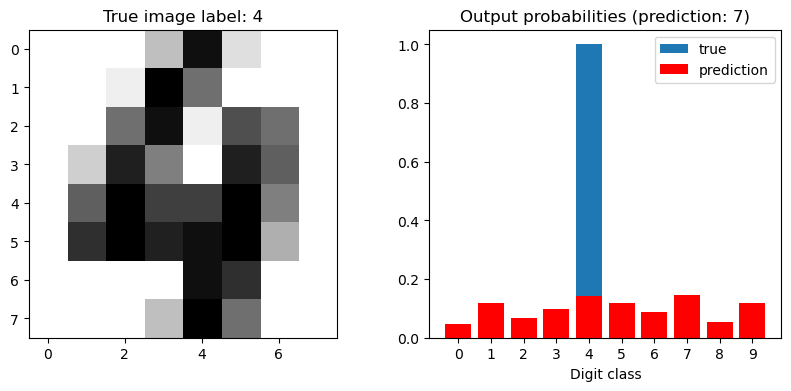

In [8]:
## Définition d'une fonction qui affiche les outputs
def plot_prediction(model, sample_idx=0, classes=range(10)):
    """
    Affiche la prédiction du modèle pour un échantillon donné et un 
    nombre de classe donné.
    """
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(scaler.inverse_transform(X_test[sample_idx]).reshape(8, 8), cmap=plt.cm.gray_r,
               interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()
    
# définition du modèle

n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))

model = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = model.loss(X_train, y_train)
train_acc = model.accuracy(X_train, y_train)
test_acc = model.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f" % (train_loss, train_acc, test_acc))

plot_prediction(model, sample_idx=0)
plt.show()


On peut à présent entrainer le modèle. Lorsqu'on entraine un modèle, on va effectuer un certain nombre d'itérations sur le dataset d'entrainement. Ces itérations sont les `epochs`. Couplées aux augmentations, le fait d'itérer plusieurs fois permet "d'augmenter" artificiellement le nombre d'échantillon vus durant l'entrainement. One boucle d'entrainement a la structure suivante:

```python
for epoch in epochs: # entrainement sur un nombre d'epochs donné

    for X_batch, y_batch in zip(X_train, y_train): # on parcourt les données d'entrainement par batch

        # prediction
        y_pred = model.predict(X_batch)

        # calcul de la perte
        loss = model.loss(y_pred, y_batch)

        # mise à jour des poids. Pour l'exemple on considère que la méthode
        # qui met à jour les poids s'appelle "update" et prend 
        # en argument la perte
        model.update_weights(loss)
```

--- Epoch 1 / 3 ---
Update #0, train loss: 2.3813, train acc: 0.090, test acc: 0.113
Update #300, train loss: 0.6144, train acc: 0.896, test acc: 0.842
Update #600, train loss: 0.3837, train acc: 0.932, test acc: 0.900
Update #900, train loss: 0.3008, train acc: 0.949, test acc: 0.909
Update #1200, train loss: 0.2490, train acc: 0.958, test acc: 0.904
--- Epoch 2 / 3 ---
Update #0, train loss: 0.2264, train acc: 0.961, test acc: 0.933
Update #300, train loss: 0.2029, train acc: 0.967, test acc: 0.920
Update #600, train loss: 0.1868, train acc: 0.966, test acc: 0.929
Update #900, train loss: 0.1716, train acc: 0.971, test acc: 0.936
Update #1200, train loss: 0.1593, train acc: 0.973, test acc: 0.936
--- Epoch 3 / 3 ---
Update #0, train loss: 0.1520, train acc: 0.976, test acc: 0.944
Update #300, train loss: 0.1436, train acc: 0.978, test acc: 0.944
Update #600, train loss: 0.1374, train acc: 0.974, test acc: 0.938
Update #900, train loss: 0.1302, train acc: 0.978, test acc: 0.940
Update

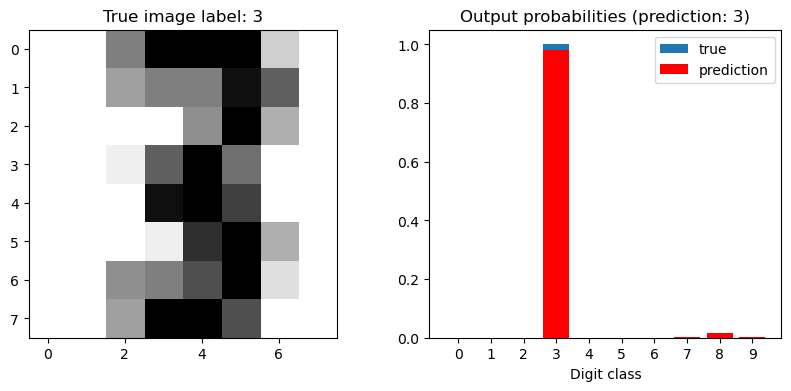

In [9]:
# on entraine le modèle pendant 3 epochs
# on définit le learning_rate à 0.01

learning_rate = 0.01
N_epochs = 3

# définition de la boucle d'entrainement

for epoch in range(N_epochs):

    print('--- Epoch', epoch+1, '/', N_epochs ,'---')

    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, learning_rate) # entrainer le modèle avec la méthode "train" (qui résume les trois étapes de l'exemple)

        # on affiche périodiquement les pertes et l'accuracy
        if i % 300 == 0:
            train_loss = model.loss(X_train, y_train) # calcul de la perte sur le test
            train_acc = model.accuracy(X_train, y_train) # calcul de l'accuracy sur le train
            test_acc = model.accuracy(X_test, y_test) # calcul de l'accuracy sur le test
            print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
                  % (i, train_loss, train_acc, test_acc))

# maintenant que notre modèle est entrainé, on peut afficher une de ses prédictions

plot_prediction(model, sample_idx=np.random.randint(0,X_test.shape[0]))
plt.show()

### Modèle feed-forward multi-couches

#### Modèle à une couche 

On va maintenant implémenter un modèle avec une couche cachée et une activation sigmoide. Ce modèle sera entrainé par rétropropagation. Avant de commencer, on définit des fonctions `sigmoid` et sa dérivée `disigmoid`, qui nous seront utiles pour la suite. 

Du point de vue des notations, on va noter $W_h$ et $b_h$ les poids de la couche cachée et $W_o$ et $b_o$ ceux de la dernière couche.

In [10]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def dsigmoid(X):
    '''Return the derivative of the sigmoid.'''
    sig = sigmoid(X)
    return sig * (1 - sig)

In [11]:
class NeuralNet():
    """
    MLP avec une couche cachée
    Dans l'initialisation, on peut définir la taille de la couche intermédiaire.
    """

    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.uniform(size=(input_size, hidden_size), low=-0.01, high=0.01)
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(size=(hidden_size, output_size), low=-0.01, high=0.01)
        self.b_o = np.zeros(output_size)
        self.output_size = output_size

    def forward(self, X, keep_activations=False):
        """
        Dans la fonction forward, on définit une option `keep_activations`
        qui renvoie les prédictions de la couche cachée en plus des prédictions
        de la dernière couche. 

        Cette option est activée quand on calcule les gradients.
        """

        z_h = np.dot(X, self.W_h) + self.b_h
        h   = sigmoid(z_h)
        z_o = np.dot(h, self.W_o) + self.b_o
        y   = softmax(z_o)


        if keep_activations:
            return y, h, z_h
        else:
            return y

    def loss(self, X, y):
        return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, x, y_true):
        y, h, z_h = self.forward(x, keep_activations=True)
        
        grad_z_o = y - one_hot(self.output_size, y_true)
        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o
        
        # Maintenant que l'on a une chouche cachée, il faut aussi 
        # calculer ses gradients
        grad_h   = np.dot(grad_z_o, np.transpose(self.W_o))
        grad_z_h = grad_h * dsigmoid(z_h)
        grad_W_h = np.outer(x, grad_z_h)
        grad_b_h = grad_z_h

        # on stocke les résultats dans un dictionnaire
        
        grads    = {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}
        return grads

    def train(self, x, y, learning_rate):
        """
        La structure est la même que pour la régression logistique
        """

        grads = self.grad_loss(x,y)
        self.W_h = self.W_h - learning_rate * grads["W_h"]
        self.b_h = self.b_h - learning_rate * grads["b_h"]
        self.W_o = self.W_o - learning_rate * grads["W_o"]
        self.b_o = self.b_o - learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis = 1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis = 1)
        return np.mean(y_preds == y)

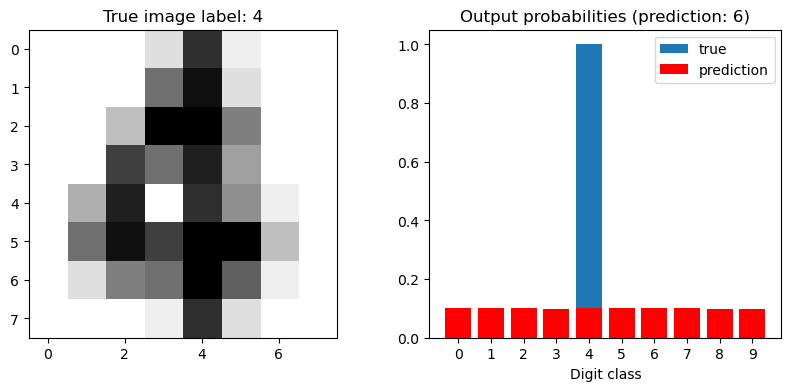

In [12]:
# on initialise un modèle et on fait une prédiction sans entrainement

n_hidden = 32 # Play with this parameter
model = NeuralNet(n_features, n_hidden, n_classes)


plot_prediction(model, sample_idx=np.random.randint(0,X_test.shape[0]))
plt.show()

On va pouvoir entrainer notre modèle. La structure est la même que précédemment. 
Durant l'entrainement, on va récupérer les pertes, que l'on affichera ensuite. Certaines librairies comme [Tensorboard](https://www.tensorflow.org/tensorboard) permettent de voir en direct l'entrainement du modèle.

Random init: train loss: 2.30278, train acc: 0.101, test acc: 0.102
Epoch #1, train loss: 0.18370, train acc: 0.959, test acc: 0.918
Epoch #11, train loss: 0.00679, train acc: 1.000, test acc: 0.953
Epoch #21, train loss: 0.00307, train acc: 1.000, test acc: 0.956
Epoch #31, train loss: 0.00198, train acc: 1.000, test acc: 0.958
Epoch #41, train loss: 0.00146, train acc: 1.000, test acc: 0.958
Epoch #51, train loss: 0.00115, train acc: 1.000, test acc: 0.958
Epoch #61, train loss: 0.00095, train acc: 1.000, test acc: 0.953
Epoch #71, train loss: 0.00081, train acc: 1.000, test acc: 0.953
Epoch #81, train loss: 0.00070, train acc: 1.000, test acc: 0.953
Epoch #91, train loss: 0.00062, train acc: 1.000, test acc: 0.953


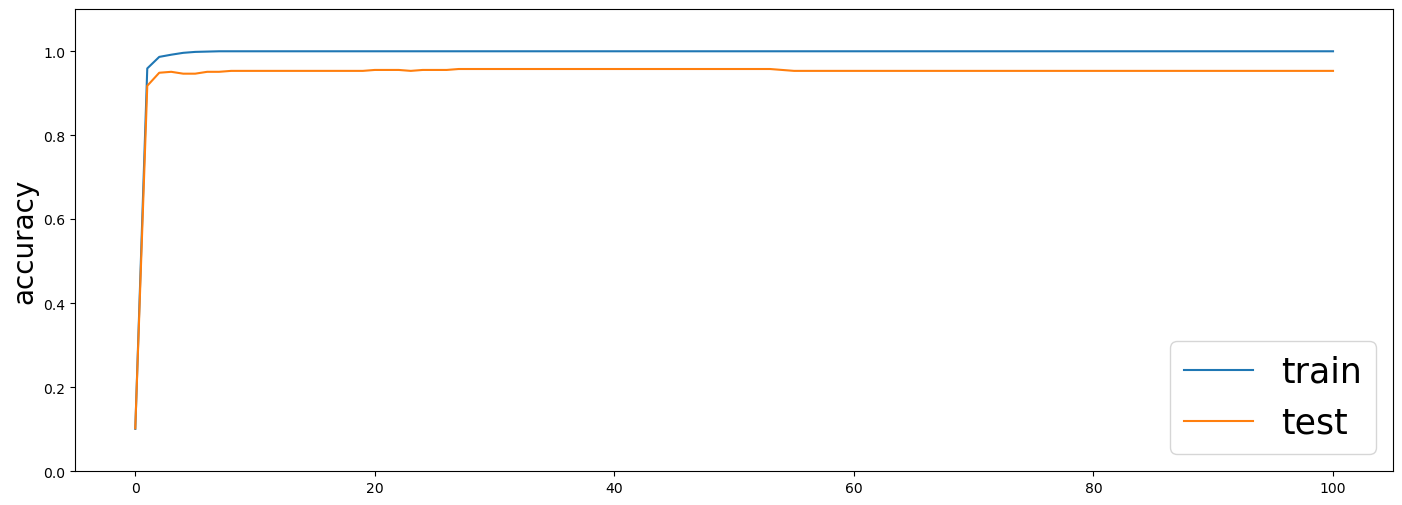

In [13]:
N_epochs = 100

model = NeuralNet(n_features, n_hidden, n_classes) # on initialise un nouveau modèle

losses, accuracies, accuracies_test = [], [], [] # listes que l'on affichera à la fin

# on ajoute les pertes avant l'entrainement
losses.append(model.loss(X_train, y_train)) 
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(N_epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))

    if epoch%10 == 0: # Afficher périodiquement les pertes
        print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
              % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

# on affiche l'accuracy sur le train et le test
plt.figure(figsize=(17,6))
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy", fontsize=20)
plt.legend(fontsize=25, loc='best')
plt.show()

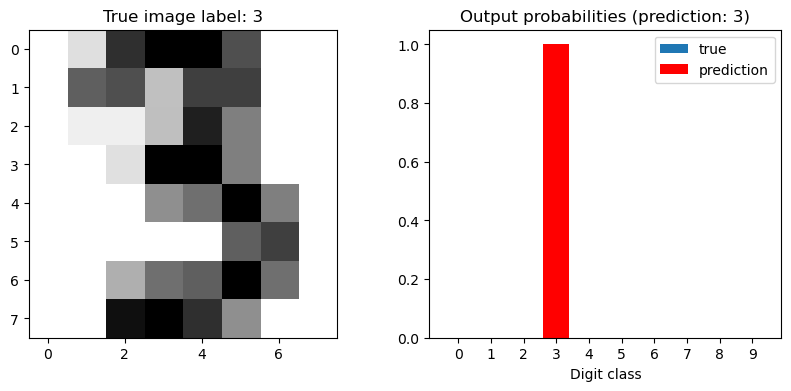

In [14]:
# on affiche un exemple de prédiction avec le modèle entrainé

plot_prediction(model, sample_idx=np.random.randint(0,X_test.shape[0]))
plt.show()

#### Variante: modèle avec deux couches cachées

On reprend la même architecture, mais cette fois-ci avec deux couches cachées. 

In [15]:
class TwoLayersNeuralNet():
    """
    MLP avec deux couches cachées
    Dans l'initialisation, on peut définir la taille de la couche intermédiaire.
    """

    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        
        self.W_h1 = np.random.uniform(size=(input_size, hidden_size_1), low=-0.01, high=0.01)
        self.b_h1 = np.zeros(hidden_size_1)

        self.W_h2 = np.random.uniform(size=(hidden_size_1, hidden_size_2), low=-0.01, high=0.01)
        self.b_h2 = np.zeros(hidden_size_2)


        self.W_o = np.random.uniform(size=(hidden_size_2, output_size), low=-0.01, high=0.01)
        self.b_o = np.zeros(output_size)

        self.output_size = output_size

    def forward(self, X, keep_activations=False):
        """
        Dans la fonction forward, on définit une option `keep_activations`
        qui renvoie les prédictions de la couche cachée en plus des prédictions
        de la dernière couche. 

        Cette option est activée quand on calcule les gradients.
        """

        z_h1 = np.dot(X, self.W_h1) + self.b_h1
        h1   = sigmoid(z_h1)

        z_h2 = np.dot(h1, self.W_h2) + self.b_h2
        h2 = sigmoid(z_h2)

        z_o = np.dot(h2, self.W_o) + self.b_o
        y   = softmax(z_o)

        if keep_activations:
            return y, h1, z_h1, h2, z_h2
        else:
            return y

    def loss(self, X, y):
        return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, x, y_true):
        y, h1, z_h1, h2, z_h2 = self.forward(x, keep_activations=True)
        
        grad_z_o = y - one_hot(self.output_size, y_true)
        grad_W_o = np.outer(h2, grad_z_o)
        grad_b_o = grad_z_o
        
        # Gradients des couches cachées par backprop
        grad_h2   = np.dot(grad_z_o, np.transpose(self.W_o))
        grad_z_h2 = grad_h2 * dsigmoid(z_h2)
        grad_W_h2 = np.outer(h1, grad_z_h2)
        grad_b_h2 = grad_z_h2

        grad_h1   = np.dot(grad_z_h2, np.transpose(self.W_h2))
        grad_z_h1 = grad_h1 * dsigmoid(z_h1)
        grad_W_h1 = np.outer(x, grad_z_h1)
        grad_b_h1 = grad_z_h1

        # on stocke les résultats dans un dictionnaire
        grads    = {
            "W_h1" : grad_W_h1,
            "b_h1" : grad_b_h1,
            "W_h2" : grad_W_h2,
            "b_h2" : grad_b_h2,
            "W_o" : grad_W_o,
            "b_o" : grad_b_o,
        }
        
        return grads

    def train(self, x, y, learning_rate):
        """
        La structure est la même que pour la régression logistique
        """

        grads = self.grad_loss(x,y)

        self.W_h1 = self.W_h1 - learning_rate * grads["W_h1"]
        self.b_h1 = self.b_h1 - learning_rate * grads["b_h1"]

        self.W_h2 = self.W_h2 - learning_rate * grads["W_h2"]
        self.b_h2 = self.b_h2 - learning_rate * grads["b_h2"]

        self.W_o = self.W_o - learning_rate * grads["W_o"]
        self.b_o = self.b_o - learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis = 1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis = 1)
        return np.mean(y_preds == y)

(1347, 64)
Random init: train loss: 2.30281, train acc: 0.098, test acc: 0.100
Epoch #1, train loss: 2.09698, train acc: 0.219, test acc: 0.200
Epoch #11, train loss: 0.10915, train acc: 0.979, test acc: 0.922
Epoch #21, train loss: 0.00728, train acc: 1.000, test acc: 0.942
Epoch #31, train loss: 0.00350, train acc: 1.000, test acc: 0.944
Epoch #41, train loss: 0.00230, train acc: 1.000, test acc: 0.949
Epoch #51, train loss: 0.00170, train acc: 1.000, test acc: 0.949
Epoch #61, train loss: 0.00135, train acc: 1.000, test acc: 0.947
Epoch #71, train loss: 0.00111, train acc: 1.000, test acc: 0.947
Epoch #81, train loss: 0.00095, train acc: 1.000, test acc: 0.947
Epoch #91, train loss: 0.00082, train acc: 1.000, test acc: 0.947


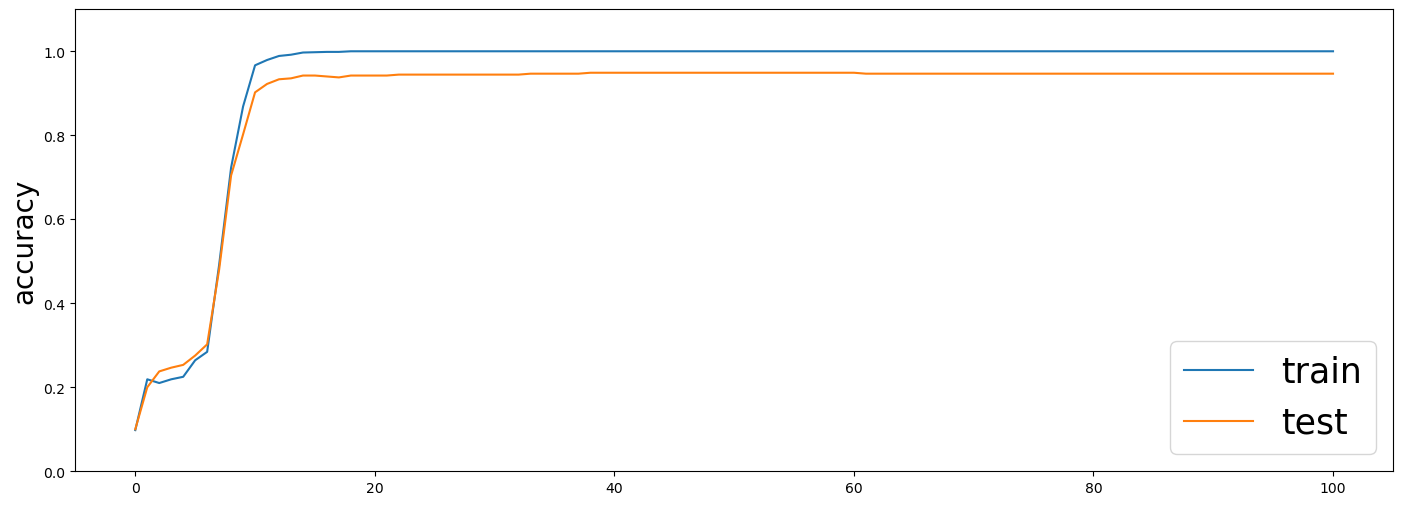

In [16]:
# Entrainement du modèle

N_epochs = 100

n_hidden_1 = 32
n_hidden_2 = 16


model = TwoLayersNeuralNet(n_features, n_hidden_1, n_hidden_2, n_classes) # on initialise un nouveau modèle

losses, accuracies, accuracies_test = [], [], [] # listes que l'on affichera à la fin


print(X_train.shape)
# on ajoute les pertes avant l'entrainement
losses.append(model.loss(X_train, y_train)) 
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(N_epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))

    if epoch%10 == 0: # Afficher périodiquement les pertes
        print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
              % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

# on affiche l'accuracy sur le train et le test
plt.figure(figsize=(17,6))
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy", fontsize=20)
plt.legend(fontsize=25, loc='best')
plt.show()

### Jeu avec le modèle

Dans cette dernière section, libre à vous d'explorer un peu le modèle. Vous pouvez par exemple:

* Regarder les pires prédictions du modèle avec la fonction `plot_prediction`
* Ajuster les hyperparamètres (le learning rate, la taille de la couche cachée, l'initialisation)
* Implémenter d'autres activations, par exemple la fonction `relu` au lieu de la fonction `sigmoid`
* Vous pouvez enfin modifier le code pour que l'entrainement soit fait non plus par donnée mais par batch de données.
* On peut également créer une classe qui permet d'initialiser un modèle avec `n` couches cachées. 

```python
# un exemple de code pour récupérer les pires prédictions du modèle

test_losses = -np.sum(np.log(EPSILON + model.forward(X_test)) * one_hot(10, y_test), axis=1)

# Sort by ascending loss: best predictions first, worst at the end
ranked_by_loss = test_losses.argsort()
```

Enfin, si vous voulez avoir des exemples visuels de réseaux de neurones, vous pouvez aller sur https://playground.tensorflow.org 